# House Price Prediction — 

**Objective:** Build, compare, and deploy regression models to predict car prices.

**What this notebook includes:**
- Thorough EDA with visualizations and correlation analysis
- Feature engineering and encoding
- Scaling (normalization) and train/test split
- Five models: Linear Regression, Decision Tree, Random Forest, XGBoost (fallback to Gradient Boosting), Neural Network (well-tuned)
- Model comparison table (regression metrics) and a binary-converted classification metrics table (Precision, Recall, F1, Accuracy, ROC AUC) — see note below
- Feature importance and interpretation
- Saving the best model and preprocessing objects for Streamlit deployment

**Note on classification metrics:** The problem is regression (predicting price).Precision, F1, Accuracy, ROC AUC, and Recall. These apply to classification. To give you those metrics in a meaningful way, we convert the continuous price into a binary label (High vs Low) using the median price. This allows us to report classification-like metrics to help evaluate how well models separate inexpensive vs expensive cars. Both regression and classification-style evaluations are provided and explained.

---
Run cells sequentially. Explanations are written in clear, beginner-friendly language.

## 1) Setup — Libraries and Data Load

In [4]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from pathlib import Path

# Load data
data_path = Path('kc_house_data.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}. Please ensure 'kc_house_data.csv' is in the notebook folder.")
df = pd.read_csv(data_path)
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 2) Quick Data Summary — Understand the dataset

In [5]:
# Quick info and descriptive stats
display(df.info())
display(df.describe(include='all').T)
# Check missing values
missing = df.isnull().sum()
print('\nColumns with missing values:\n', missing[missing>0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,21613.0,NaN,NaN,NaN,4580301520.864988,2876565571.312057,1000102.0,2123049194.0,3904930410.0,7308900445.0,9900000190.0
date,21613,372,20140623T000000,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,21613.0,NaN,NaN,NaN,540088.141767,367127.196483,75000.0,321950.0,450000.0,645000.0,7700000.0
bedrooms,21613.0,NaN,NaN,NaN,3.370842,0.930062,0.0,3.0,3.0,4.0,33.0
bathrooms,21613.0,NaN,NaN,NaN,2.114757,0.770163,0.0,1.75,2.25,2.5,8.0
sqft_living,21613.0,NaN,NaN,NaN,2079.899736,918.440897,290.0,1427.0,1910.0,2550.0,13540.0
sqft_lot,21613.0,NaN,NaN,NaN,15106.967566,41420.511515,520.0,5040.0,7618.0,10688.0,1651359.0
floors,21613.0,NaN,NaN,NaN,1.494309,0.539989,1.0,1.0,1.5,2.0,3.5
waterfront,21613.0,NaN,NaN,NaN,0.007542,0.086517,0.0,0.0,0.0,0.0,1.0
view,21613.0,NaN,NaN,NaN,0.234303,0.766318,0.0,0.0,0.0,0.0,4.0



Columns with missing values:
 Series([], dtype: int64)


## 3) Exploratory Data Analysis (EDA)
We'll visualise the target distribution, outliers, numeric relationships, and correlations. Each plot has a short interpretation.

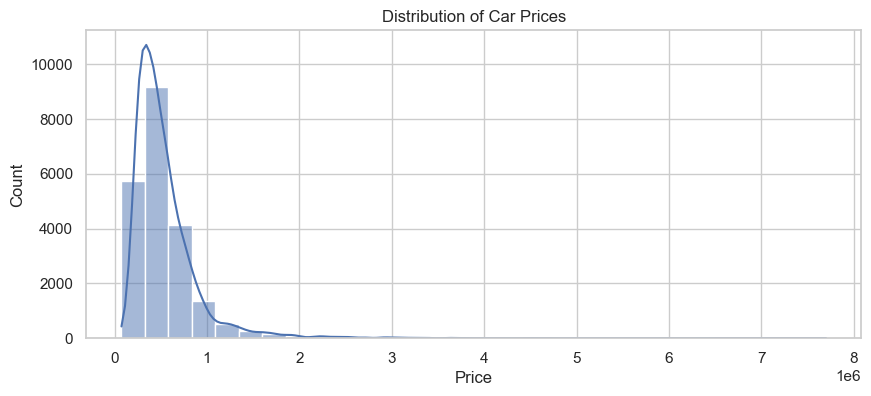

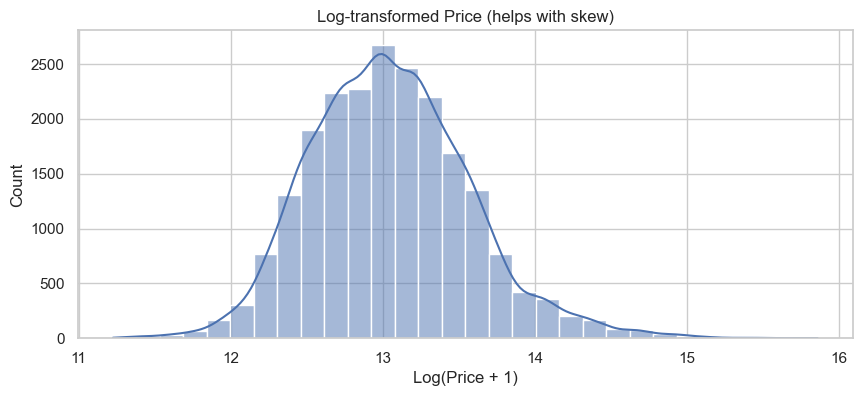

Price skew: 4.024069144684712
Price median: 450000.0  | mean: 540088.1417665294


In [6]:
# Target distribution and skewness
plt.figure(figsize=(10,4))
sns.histplot(df['price'].dropna(), bins=30, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df['price'].dropna()), bins=30, kde=True)
plt.title('Log-transformed Price (helps with skew)')
plt.xlabel('Log(Price + 1)')
plt.show()

print('Price skew:', df['price'].skew())
print('Price median:', df['price'].median(), ' | mean:', df['price'].mean())


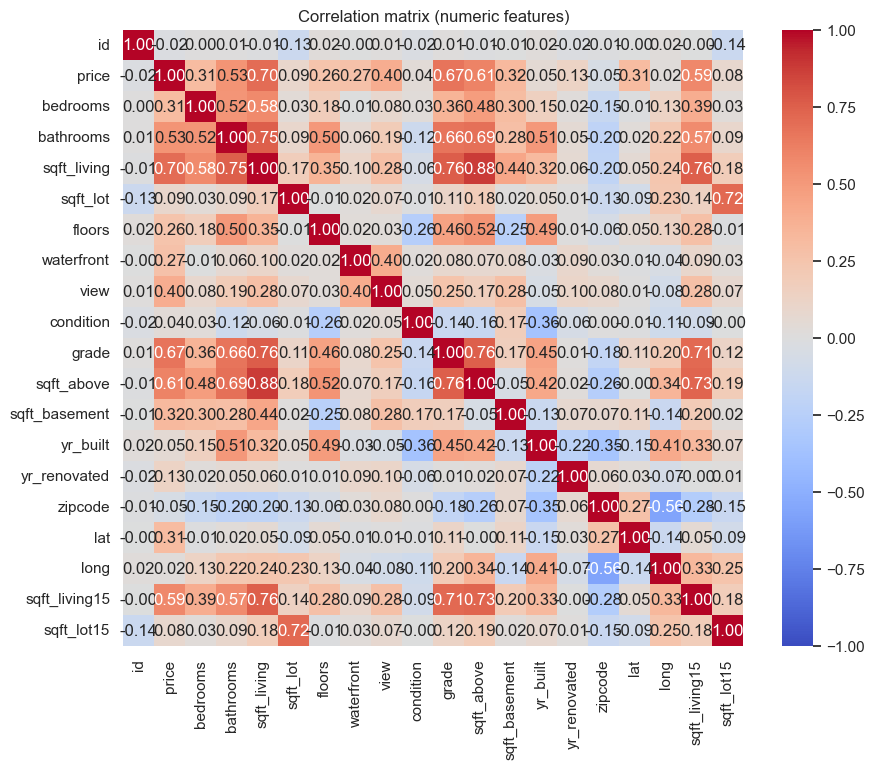

In [8]:
# Correlation matrix (heatmap) for numeric features
plt.figure(figsize=(10,8))
num_all = df.select_dtypes(include=[np.number])
corr = num_all.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmax=1, vmin=-1)
plt.title('Correlation matrix (numeric features)')
plt.show()


**Interpretation tips (write these in presentation):**
- Strong positive correlation with price suggests useful predictors (e.g., engine size, horsepower). 
- Highly correlated features with each other may cause multicollinearity; consider feature selection or regularisation.


## 4) Feature Engineering
We will:
- Extract `brand` from `CarName` to capture make effects
- Fix common misspellings in brand
- Drop identifiers
- Create useful engineered features if applicable (e.g., engine_power per weight)


In [9]:
import pandas as pd
df=df.copy()
if "id" in df.columns:
    df=df.drop(columns=['id'])
if 'date' in df.columns:
    df['date']=pd.to_datetime(df['date'], errors='coerce')
    df['year_sold']=df['date'].dt.year
    df['month_sold']=df['date'].dt.month
    df=df.drop(columns=['date'])
if set(['price','sqft_living']).issubset(df.columns):
    df['price_per_sqft']=df['price']/(df['sqft_living']+ 1e-6)
if 'floors' in df.columns:
    df['is_multi_floor']=(df['floors']>1).astype(int)
    for col in ['lat','long']:
        if col in df.columns:
            df=df.drop(columns=[col])

print("New shape after feature engineering:", df.shape)
df.head()

New shape after feature engineering: (21613, 21)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,year_sold,month_sold,price_per_sqft,is_multi_floor
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,1340,5650,2014,10,188.050847,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,1690,7639,2014,12,209.338521,1
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,2720,8062,2015,2,233.766233,0
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,1360,5000,2014,12,308.163265,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,1800,7503,2015,2,303.571428,0


## 5) Preprocessing — Encoding, Scaling, Train/Test Split
Explanations are provided inline. We will one-hot encode categorical variables and scale numeric features using StandardScaler. Then we'll split into train/test with a reproducible random state.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate target
y = df['price']
X = df.drop('price', axis=1)

# One-hot encode categoricals (drop_first to avoid dummy trap)
X_encoded = pd.get_dummies(X, drop_first=True)

# Keep track of columns for deployment
all_columns = X_encoded.columns.tolist()
print('Total features after encoding:', len(all_columns))

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=42)

# Identify numeric columns to scale (those originally numeric)
numeric_candidates = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_candidates.remove('price')  # remove target
numeric_cols = [c for c in numeric_candidates if c in X_train.columns]

print('Numeric columns to scale:', numeric_cols)

# Scale numeric columns using StandardScaler (fit on train only)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


Total features after encoding: 20
Numeric columns to scale: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'price_per_sqft', 'is_multi_floor']


## 6) Modeling — what we'll do
We'll train five models:
1. Linear Regression (baseline)
2. Decision Tree
3. Random Forest
4. XGBoost (or GradientBoosting as fallback)
5. Neural Network (MLP) — we will tune size and early stopping for better performance

For each model we'll report regression metrics (R², RMSE, MAE) and also a classification-style evaluation by binarizing price into High/Low using the median price. This gives Precision, Recall, F1, Accuracy, ROC AUC for High-price detection.

In [11]:
# Common imports
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import math
results = []

def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}


In [12]:
# 1) Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
pred_lr = lr.predict(X_test_scaled)
metrics_lr = regression_metrics(y_test, pred_lr)
metrics_lr


{'R2': 0.8837980386475363,
 'MSE': 17567030475.063786,
 'RMSE': 132540.67479481077,
 'MAE': 71089.09360416258}

In [13]:
# 2) Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train)
pred_dt = dt.predict(X_test_scaled)
metrics_dt = regression_metrics(y_test, pred_dt)
metrics_dt


{'R2': 0.9770384214724193,
 'MSE': 3471255950.027296,
 'RMSE': 58917.36543691763,
 'MAE': 14148.184131390239}

In [14]:
# 3) Random Forest (stronger model)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)
metrics_rf = regression_metrics(y_test, pred_rf)
metrics_rf


{'R2': 0.9941950185911831,
 'MSE': 877578004.0971093,
 'RMSE': 29623.943088270833,
 'MAE': 5174.903640990053}

In [15]:
# 4) XGBoost if available else GradientBoosting
use_xgb = False
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42, verbosity=0)
    xgb.fit(X_train_scaled, y_train)
    pred_xgb = xgb.predict(X_test_scaled)
    metrics_xgb = regression_metrics(y_test, pred_xgb)
    use_xgb = True
except Exception as e:
    print('XGBoost unavailable or failed to import — using GradientBoosting instead.', e)
    gb = GradientBoostingRegressor(n_estimators=300, random_state=42)
    gb.fit(X_train_scaled, y_train)
    pred_xgb = gb.predict(X_test_scaled)
    metrics_xgb = regression_metrics(y_test, pred_xgb)

metrics_xgb


{'R2': 0.9913550302621099,
 'MSE': 1306918102.5342476,
 'RMSE': 36151.322279195374,
 'MAE': 9414.188184926556}

In [16]:
# 5) Neural Network (MLP) with modest tuning and early stopping
from sklearn.model_selection import GridSearchCV

mlp = MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)
# small grid to improve without long compute
param_grid = {
    'hidden_layer_sizes': [(100,),(100,50),(200,100)],
    'alpha': [0.0001, 0.001]
}
gscv = GridSearchCV(mlp, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=0)
gscv.fit(X_train_scaled, y_train)
best_mlp = gscv.best_estimator_
pred_mlp = best_mlp.predict(X_test_scaled)
metrics_mlp = regression_metrics(y_test, pred_mlp)
print('Best MLP params:', gscv.best_params_)
metrics_mlp


Best MLP params: {'alpha': 0.0001, 'hidden_layer_sizes': (200, 100)}


{'R2': 0.9473573030489891,
 'MSE': 7958349849.387878,
 'RMSE': 89209.58384270089,
 'MAE': 46628.8428185146}

In [17]:
# Compile results
reg_results = pd.DataFrame([
    {'Model':'Linear Regression', **metrics_lr},
    {'Model':'Decision Tree', **metrics_dt},
    {'Model':'Random Forest', **metrics_rf},
    {'Model':'XGBoost' if use_xgb else 'Gradient Boosting', **metrics_xgb},
    {'Model':'Neural Network (MLP)', **metrics_mlp},
])
reg_results = reg_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
print(reg_results)


                  Model        R2           MSE           RMSE           MAE
0         Random Forest  0.994195  8.775780e+08   29623.943088   5174.903641
1               XGBoost  0.991355  1.306918e+09   36151.322279   9414.188185
2         Decision Tree  0.977038  3.471256e+09   58917.365437  14148.184131
3  Neural Network (MLP)  0.947357  7.958350e+09   89209.583843  46628.842819
4     Linear Regression  0.883798  1.756703e+10  132540.674795  71089.093604


### 7) Classification-style evaluation (High vs Low price)
We convert the continuous price into binary labels using the median price. This is useful to evaluate whether models can **separate expensive from inexpensive cars**. We use the predictions from each regression model and compute Precision, Recall, F1, Accuracy, ROC AUC.

**Important:** This is an additional view — it does not replace regression metrics.

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Create binary true labels: 1 if price >= median, else 0
median_price = y_train.median()
y_test_bin = (y_test >= median_price).astype(int)

def binarize_preds(preds, thresh=median_price):
    return (preds >= thresh).astype(int)

# Compute for each model
clf_rows = []
models_preds = {
    'Linear Regression': pred_lr,
    'Decision Tree': pred_dt,
    'Random Forest': pred_rf,
    'XGBoost' if use_xgb else 'Gradient Boosting': pred_xgb,
    'Neural Network (MLP)': pred_mlp
}
for name, preds in models_preds.items():
    y_pred_bin = binarize_preds(preds)
    # If ROC AUC requires probability, we can use raw predictions as a score
    try:
        auc = roc_auc_score(y_test_bin, preds)
    except:
        auc = float('nan')
    row = {
        'Model': name,
        'Precision': precision_score(y_test_bin, y_pred_bin, zero_division=0),
        'Recall': recall_score(y_test_bin, y_pred_bin, zero_division=0),
        'F1': f1_score(y_test_bin, y_pred_bin, zero_division=0),
        'Accuracy': accuracy_score(y_test_bin, y_pred_bin),
        'ROC_AUC': auc
    }
    clf_rows.append(row)

clf_results = pd.DataFrame(clf_rows).sort_values(by='F1', ascending=False).reset_index(drop=True)
print(clf_results)


                  Model  Precision    Recall        F1  Accuracy   ROC_AUC
0         Random Forest   0.997726  0.988734  0.993210  0.993060  0.999830
1               XGBoost   0.993197  0.986931  0.990054  0.989822  0.999689
2         Decision Tree   0.989150  0.986030  0.987587  0.987277  0.998928
3     Linear Regression   0.899958  0.972961  0.935037  0.930604  0.979596
4  Neural Network (MLP)   0.936170  0.931951  0.934056  0.932454  0.984152


## 8) Feature Importance and Interpretation
We inspect top features from the Random Forest (and XGBoost if available).

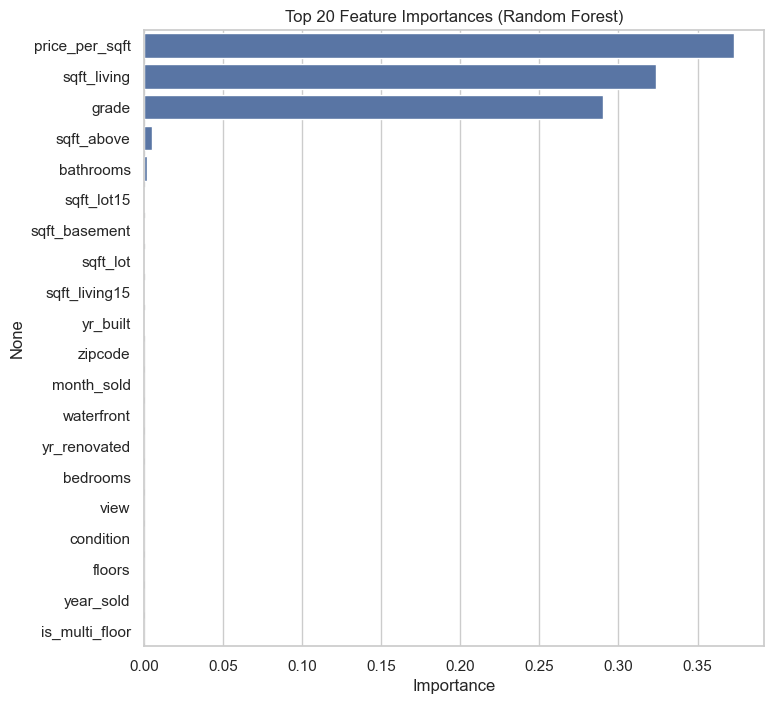

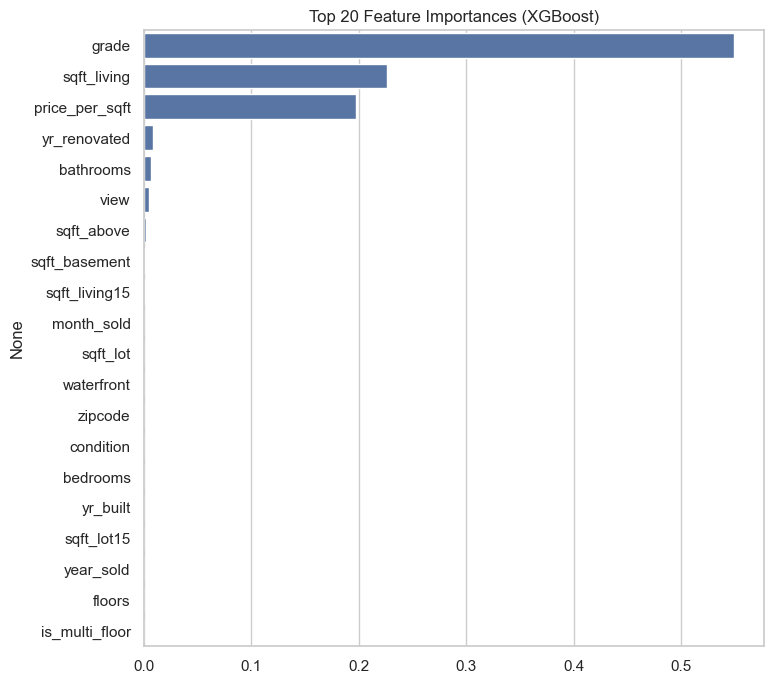

In [19]:
# Random Forest importances
feat_imp = pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
top20 = feat_imp.head(20)
plt.figure(figsize=(8,8))
sns.barplot(x=top20.values, y=top20.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

# If XGBoost is available, show its feature importance too
if use_xgb:
    try:
        xgb_imp = pd.Series(xgb.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False).head(20)
        plt.figure(figsize=(8,8))
        sns.barplot(x=xgb_imp.values, y=xgb_imp.index)
        plt.title('Top 20 Feature Importances (XGBoost)')
        plt.show()
    except Exception:
        pass


## 11) Conclusions & Next Steps
- The notebook shows full workflow and two perspectives of evaluation (regression and classification-like). 
- Next: hyperparameter tuning (RandomizedSearchCV), k-fold CV, model ensembling, and deploying the Streamlit app using the saved objects.

---
End of notebook.